<a href="https://colab.research.google.com/github/cgpan/predict_stock_lstm/blob/main/Predict_the_Stock_Price_Using_LSTM_V3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stage 1. Stock Data Management Using Yfinance

In [ ]:
# Since the google's remote server does not have a module called yfinance
# !pip install yfinance

## 1.0 install and import the module yfinance

see this page for more tutorials https://analyzingalpha.com/yfinance-python

In [ ]:
import yfinance as yf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

## 2.0 get the stock price data using .history()

关于.history()的source code 可以提供各种参数的介绍，可以点击上述网址

In [ ]:
# 通过input的形式进行交互
input = {"stock_code":"EDU",
         "how_long":"2y",
         "time_interval":"1d",
         "end_date": None,
         "days2predict": 60
         }

In [ ]:
def get_stock(code, lasting, time_interval, enddate):
  """
  code must be the stock's listed code in string
  lasting is how recent the data you want to get, 
  lasting must be from one of "1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max" in string
  start date string (YYYY-MM-DD) or _datetime. Default is 1900-01-01.
  end date string (YYYY-MM-DD) or _datetime. Default is now
  Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
  """
  # make sure the ticker's code, like "AAPL" for aplle inc.
  ticker_ = yf.Ticker(code)
  # by default the .history() will give one month daily price of a ticker
  stock = ticker_.history(period=lasting, interval=time_interval, end= enddate)
  # note. yfinance 返回的值是将date作为默认索引列
  stock= stock.reset_index(level="Date")

  plt.plot(stock["Date"], stock["Close"])
  plt.xlabel("Date")
  plt.ylabel("Price")
  plt.show()
  return stock

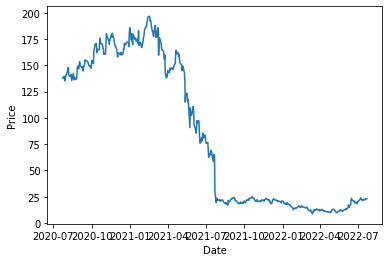

In [ ]:
stock = get_stock(input["stock_code"], input["how_long"], input["time_interval"], input["end_date"])

## 4.0 Data Management

### 4.1 Change data frame to use prices n days before to predict the target day's

Since we only care about the close price and the date, so we will remove all other variables.
In lstm we use the previous 3 days to predict the 4th day's price, thus the final sheet will be like  
[index, target-date, target-3, target-2,target-1, target]

In [ ]:
def target_df(df, days):
    """
    这个函数的作用是对于任意传入的dataframe, 按照自定义的天数re-scale成我们需要的表格，类似
    [index, target-date, target-3, target-2,target-1, target]
    对于任意天数days，前n天的范围就是 range(1, days)即1 to days-1
    """
    df_ = df[["Date", "Close"]]
    target = []
    # 生成column name 对应Target-3, Target-2， Target-1
    for i in df_.index:
        if (i+1) >= days:
            target_unit = {}
            target_unit["Date"] = df_.iloc[i,0]
            target_unit["Target"] = df_.iloc[i,1]
            for n in range(1, days):
                name = "Target-" + str(n)
                target_unit[name] = df_.iloc[i-n, 1]
            target.append(target_unit)
    data_set = pd.DataFrame(target)

    # 生成一个list 按照倒序的方式 方便对于dataframe进行columns reorder
    num_list = []
    for i in range(days):
      num_list.append(i+1)
    num_list.sort(reverse=True)
    # 在numbers list 最初位置加入0，即按照[0,n,n-1,n-2,...1]的顺序reorder the colums of df
    num_list.insert(0,0)

    dataset = data_set.iloc[:, num_list]

    return dataset

In [ ]:
dataset = target_df(stock, input["days2predict"])

In [ ]:
dataset.tail()

,Date,Target-59,Target-58,Target-57,Target-56,Target-55,Target-54,Target-53,Target-52,Target-51,...,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
440,2022-07-18,10.19,10.23,10.40,9.75,10.79,11.25,12.55,12.87,13.15,...,22.490000,22.440001,22.750000,23.799999,21.100000,21.440001,22.469999,21.980000,22.299999,22.000000
441,2022-07-19,10.23,10.40,9.75,10.79,11.25,12.55,12.87,13.15,13.07,...,22.440001,22.750000,23.799999,21.100000,21.440001,22.469999,21.980000,22.299999,22.000000,23.010000
442,2022-07-20,10.40,9.75,10.79,11.25,12.55,12.87,13.15,13.07,12.51,...,22.750000,23.799999,21.100000,21.440001,22.469999,21.980000,22.299999,22.000000,23.010000,23.010000
443,2022-07-21,9.75,10.79,11.25,12.55,12.87,13.15,13.07,12.51,12.20,...,23.799999,21.100000,21.440001,22.469999,21.980000,22.299999,22.000000,23.010000,23.010000,23.059999
444,2022-07-22,10.79,11.25,12.55,12.87,13.15,13.07,12.51,12.20,10.20,...,21.100000,21.440001,22.469999,21.980000,22.299999,22.000000,23.010000,23.010000,23.059999,23.000000


In [ ]:
dataset.shape

(445, 61)

### 4.2 Change the cleaned df to numpy.array

In [ ]:
# define a function to change any pandas's dataframe into numpy array
def df_to_tensor(df):
    df_as_np = df.to_numpy()
    
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    # need to transpose the target-3 2 1
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1],1))
    
    Y = df_as_np[:, -1]
    
    return dates, X.astype(np.float32), Y.astype(np.float32)

In [ ]:
dates, X, y = df_to_tensor(dataset)

In [ ]:
# 其中X.shape中our input matrix is 3*1 means we are looking for 3 steps in the past for only one type of variable!
dates.shape, X.shape, y.shape

((445,), (445, 59, 1), (445,))

## 5.0 Split the original data into train, validate, and test dataset

In [ ]:
# use the first 80% as training dataset. 80~90% as validating, the last 10% as test
q_80 = int(len(dates)* 0.8)
q_90 = int(len(dates)* 0.9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

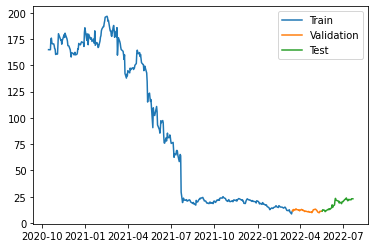

In [ ]:
# visualize these 3 datasets
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.legend(["Train","Validation","Test"])

# Stage 2. Build the LSTM Neural Networks!

## 6.0 Import the modules

In [ ]:
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras import layers

In [ ]:
model = Sequential()
model.add(layers.Input(shape = (input["days2predict"]-1,1)))
model.add(layers.LSTM(128))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))

model.compile(loss="mse", optimizer = Adam(learning_rate = 0.001), metrics = ["mean_absolute_error"])
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=150)

Epoch 1/150
12/12 [==============================] - 2s 47ms/step - loss: 12555.0566 - mean_absolute_error: 87.5719 - val_loss: 69.4016 - val_mean_absolute_error: 8.2622
Epoch 2/150
12/12 [==============================] - 0s 10ms/step - loss: 12164.5215 - mean_absolute_error: 84.5573 - val_loss: 4.3176 - val_mean_absolute_error: 1.7914
Epoch 3/150
12/12 [==============================] - 0s 9ms/step - loss: 11372.9170 - mean_absolute_error: 78.5560 - val_loss: 65.0878 - val_mean_absolute_error: 7.9971
Epoch 4/150
12/12 [==============================] - 0s 9ms/step - loss: 10030.6992 - mean_absolute_error: 73.0485 - val_loss: 371.6392 - val_mean_absolute_error: 19.2509
Epoch 5/150
12/12 [==============================] - 0s 9ms/step - loss: 7748.6616 - mean_absolute_error: 68.4384 - val_loss: 1068.5250 - val_mean_absolute_error: 32.6746
Epoch 6/150
12/12 [==============================] - 0s 9ms/step - loss: 5406.2339 - mean_absolute_error: 61.6433 - val_loss: 1399.8024 - val_mean_abs

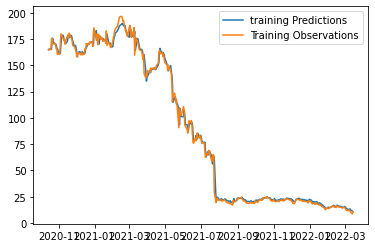

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.clf()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(["training Predictions", "Training Observations"])

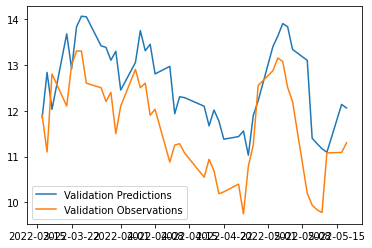

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(["Validation Predictions", "Validation Observations"])

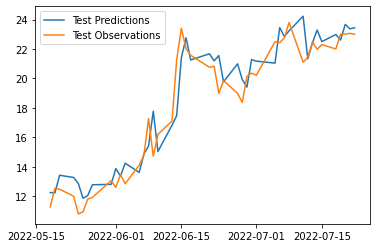

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(["Test Predictions", "Test Observations"])

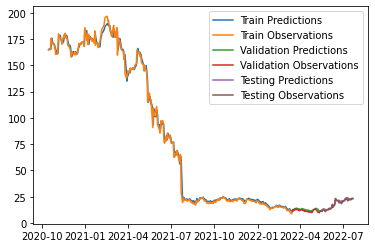

In [ ]:
# put all plot on the same figure
plt.clf()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(["Train Predictions", "Train Observations",
            "Validation Predictions", "Validation Observations",
            "Testing Predictions", "Testing Observations"])

## Stage 3. To predict the long term

In [ ]:
from copy import deepcopy
# built-in function shallow copy will change the original list
# deepcopy will not change the original list
recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

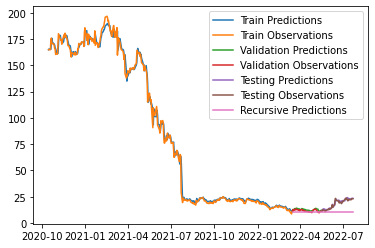

In [ ]:
# put all plot on the same figure
plt.clf()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(["Train Predictions", "Train Observations",
            "Validation Predictions", "Validation Observations",
            "Testing Predictions", "Testing Observations", "Recursive Predictions"])

In [ ]:
days_input = np.array(dataset.iloc[-1, 2:]).astype(np.float32).reshape(1,input["days2predict"]-1,1)
days_input

array([[[11.25],
        [12.55],
        [12.87],
        [13.15],
        [13.07],
        [12.51],
        [12.2 ],
        [10.2 ],
        [ 9.94],
        [ 9.84],
        [ 9.78],
        [11.08],
        [11.09],
        [11.3 ],
        [11.27],
        [12.55],
        [12.48],
        [12.  ],
        [10.8 ],
        [10.94],
        [11.81],
        [11.92],
        [13.06],
        [12.6 ],
        [13.46],
        [12.85],
        [14.11],
        [14.78],
        [17.27],
        [14.72],
        [16.21],
        [17.1 ],
        [21.27],
        [23.41],
        [22.02],
        [21.57],
        [20.76],
        [20.82],
        [18.98],
        [19.85],
        [18.99],
        [18.37],
        [20.14],
        [20.36],
        [20.21],
        [22.49],
        [22.44],
        [22.75],
        [23.8 ],
        [21.1 ],
        [21.44],
        [22.47],
        [21.98],
        [22.3 ],
        [22.  ],
        [23.01],
        [23.01],
        [23.06],
        [23.  

In [ ]:
X_test[-1:].shape

(1, 59, 1)

In [ ]:
last_day = model.predict(X_test[-1:])
print(last_day)

[[23.438753]]


In [ ]:
# to predict the next day's price
next_day = model.predict(days_input)
print("基于过去{}的走势，以{}天为一周期的LSTM预测{}明日收盘价为：".format(input["how_long"],str(input["days2predict"]),input["stock_code"]), next_day)

基于过去2y的走势，以60天为一周期的LSTM预测EDU明日收盘价为： [[23.377592]]
